In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data

from edward.models import Normal, Bernoulli, Empirical
import edward as ed

In [2]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [4]:
# =============================== Q(z|X) Encoder ======================================

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, reuse=True):
    with tf.variable_scope('encoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
        z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
        z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

# =============================== Sampling Helper ======================================
def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) Decoder ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, reuse=True):
    with tf.variable_scope('decoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
        logits = tf.matmul(h, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits



In [5]:
# =============================== DEFINE LOSS ====================================
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

# sess = tf.Session()
sess = ed.get_session() # need to make sure tf and edward share the global session
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

In [ ]:
# =============================== TRAINING ====================================
i = 0
max_iter = 20000

for it in range(max_iter):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

## Check that VAE can Reconstruct GT

In [ ]:
plt.close('all')
%matplotlib inline

num_checks = 1
x_gt, _ = mnist.train.next_batch(num_checks)
plot(x_gt)
plot(P(Q(x_gt)[0])[0].eval())
_ = 1 # prevent repeated plot in jupyter

In [8]:
def init_uninited_vars():
    unint_vars = []
    for var in tf.global_variables():
        if not tf.is_variable_initialized(var).eval():
            unint_vars.append(var)
    missingVarInit = tf.variables_initializer (unint_vars)
    sess.run(missingVarInit)

## HMC Inference

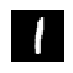

In [47]:
%matplotlib inline

inference_batch_size = 1
x_gt, _ = mnist.train.next_batch(inference_batch_size)
plot(x_gt)

T = 5000 # number of empirical samples in posterior
img_dim = 28
hmc_steps = T
leap_steps = 2

z = Normal(loc=tf.zeros([inference_batch_size, z_dim]), scale=tf.ones([inference_batch_size, z_dim])) # sample z

_, dec_x_logits = P(z)
X = Bernoulli(logits=dec_x_logits)

# X = Normal(loc=dec_x, scale=tf.ones(img_dim)*sig) # likelihood distrib
qz = Empirical(params=tf.Variable(tf.zeros([T, inference_batch_size, z_dim])))

inference = ed.HMC({z: qz}, data={X: x_gt})

inference.initialize(step_size=0.05, n_steps=leap_steps)
init_uninited_vars()

In [ ]:
plt.plot(tf.squeeze(qz.params, 1).eval());

In [48]:
for i in range(hmc_steps):
    info_dict = inference.update()
    inference.print_progress(info_dict)

# inference.finalize()
# inference.run(variables=[], n_steps=hmc_steps)

5000/5000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 0.981


In [61]:
all_zeros = tf.Variable(tf.zeros([1, z_dim]))
sess.run(tf.variables_initializer([all_zeros]))
zeros_img, _ = P(all_zeros)
plot(zeros_img.eval())

AttributeError: 'Tensor' object has no attribute 'initializer'

In [ ]:
# inference.update()
keep_ratio = 0.2
to_keep_index = int((1-keep_ratio)*T)
qz_kept = Empirical(qz.params[to_keep_index:])

z_test = tf.squeeze(qz_kept.sample(1), 0)
print(z_test.eval())
img, _ = P(z_test)
plot(img.eval())

## Sample from Posterior and Reconstruct Image

In [ ]:
sample_to_vis = 5
qz_sample = qz_kept.sample(sample_to_vis)

for i in range(sample_to_vis):
    img, _ = P(qz_sample[i])
    plot(img.eval())
    
avg_img, _ = P(tf.reduce_mean(qz_sample, 0))
plot(avg_img.eval())